#**Project Overview**
---
This project's objective is to analyze patterns in traffic congestion, and based on this pattern, create a model that would be able to reliably identify said traffic congestion.

https://drive.google.com/file/d/1jHkNqPwGuhY0GNQERkPs0BZcxKDHQIP1/view?usp=sharing

note: in order to make it easier to extract, it is decided that the data would be placed inside github

#**Importing Libraries**
---

In [487]:
!pip install skfeature-chappers

In [488]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import chi2, f_classif, SelectKBest, RFECV, VarianceThreshold
from sklearn.inspection import permutation_importance
from imblearn.under_sampling import RandomUnderSampler
from skfeature.function.sparse_learning_based import MCFS

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, precision_recall_curve, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

#**Data Loading**
---

In [489]:
df = pd.read_csv('https://raw.githubusercontent.com/comradeftj/Datsets/refs/heads/main/Traffic_Congestion_DA.csv')
df.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


#**Exploratory Data Analysis - EDA**
---

##**1. Data Description**
---

###a. Data Type Description

In [490]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


###b. Descriptive Statistics

In [491]:
df.describe(include='all')

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
count,2976,2976.000000,2976,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976
unique,96,NaN,7,NaN,NaN,NaN,NaN,NaN,4
top,12:00:00 AM,NaN,Tuesday,NaN,NaN,NaN,NaN,NaN,normal
freq,31,NaN,480,NaN,NaN,NaN,NaN,NaN,1669
mean,NaN,16.000000,NaN,68.696573,14.917339,15.279570,15.324933,114.218414,NaN
std,NaN,8.945775,NaN,45.850693,12.847518,14.341986,10.603833,60.190627,NaN
min,NaN,1.000000,NaN,6.000000,0.000000,0.000000,0.000000,21.000000,NaN
25%,NaN,8.000000,NaN,19.000000,5.000000,1.000000,6.000000,55.000000,NaN
50%,NaN,16.000000,NaN,64.000000,12.000000,12.000000,14.000000,109.000000,NaN
75%,NaN,24.000000,NaN,107.000000,22.000000,25.000000,23.000000,164.000000,NaN


##**2. Duplicate Data Detection**
---

In [492]:
df.duplicated().sum()

np.int64(0)

##**3. Data Distribution**
---

###a. Numeric Data

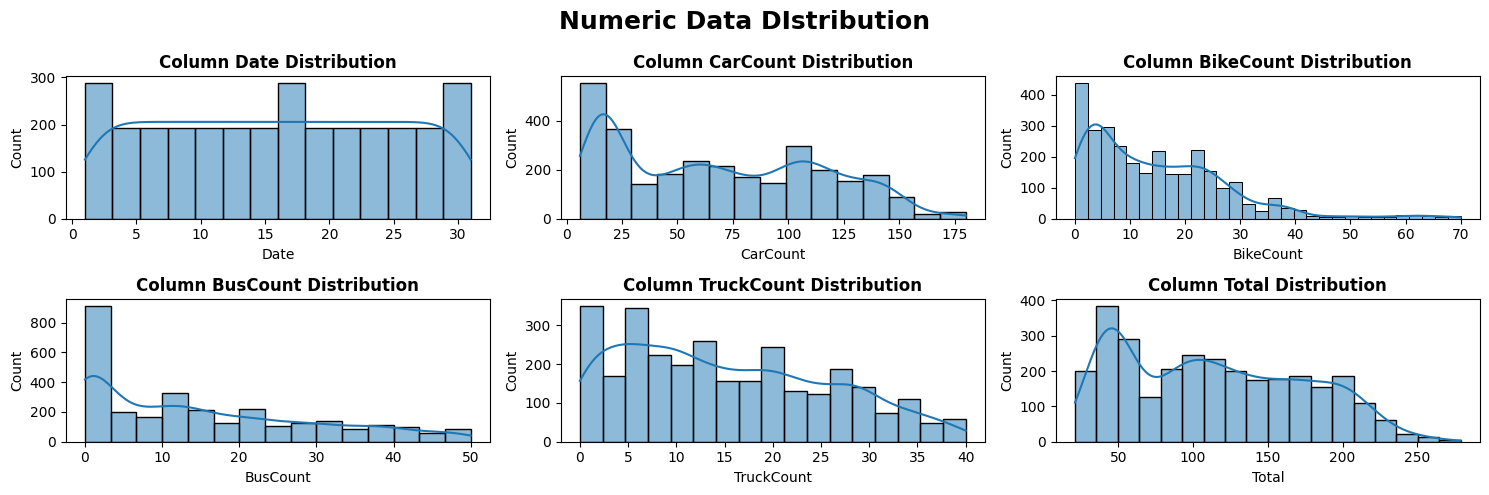

In [493]:
numeric = df.select_dtypes(include='number')

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric.columns):
  plt.subplot(2, 3, i+1)
  sns.histplot(df[col], kde=True)
  plt.title(f'Column {col} Distribution', fontsize=12, fontweight='bold')
plt.suptitle('Numeric Data DIstribution', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

###b. Categorical Data

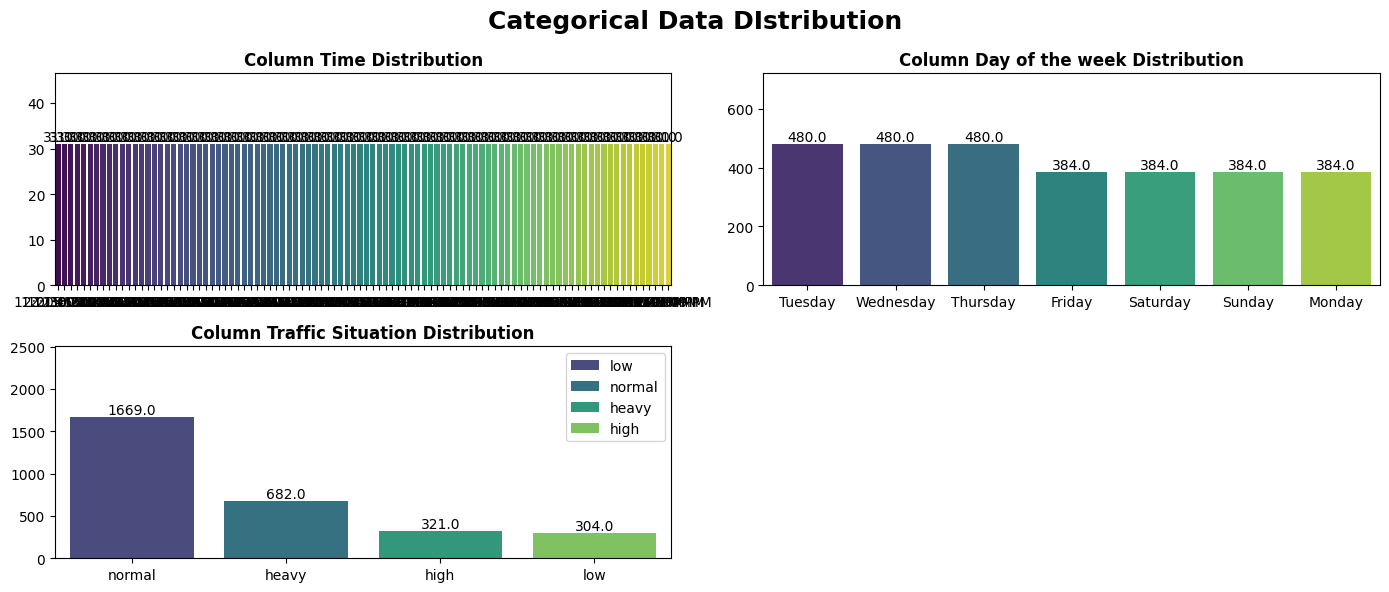

In [494]:
categorical = df.select_dtypes(include='object')

plt.figure(figsize=(14, 6))
for i, col in enumerate(categorical.columns):
  plt.subplot(2, 2, i+1)
  counts = df[col].value_counts()
  ax = sns.barplot(x=counts.index.tolist(), y=counts.values.tolist(), hue=df[col].unique(), palette='viridis')
  for value in ax.containers:
    label = [val.get_height() for val in value]
    ax.bar_label(value, labels=label, label_type='edge')
  plt.title(f'Column {col} Distribution', fontsize=12, fontweight='bold')
  plt.ylim(ymax=counts.max() + (counts.max() / 2))
plt.suptitle('Categorical Data DIstribution', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

##**3. Outlier Detection**
---

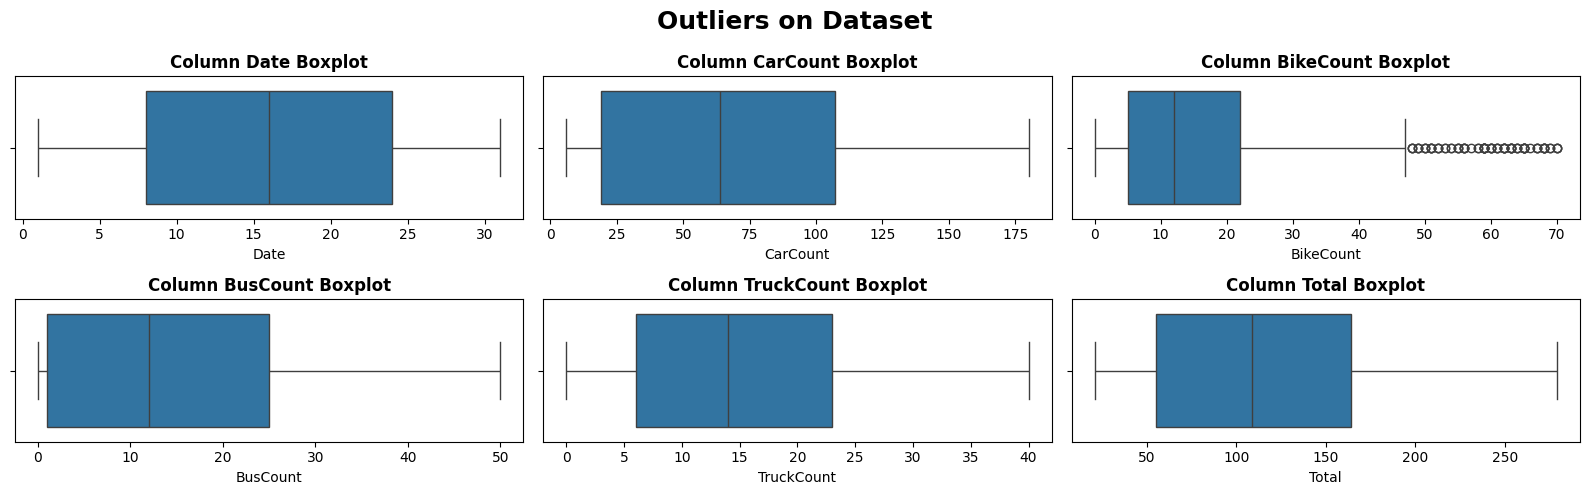

In [495]:
numeric = df.select_dtypes(include='number')

plt.figure(figsize=(16, 5))
for i, col in enumerate(numeric.columns):
  plt.subplot(2, 3, i+1)
  sns.boxplot(x=df[col])
  plt.title(f'Column {col} Boxplot', fontsize=12, fontweight='bold')
plt.suptitle('Outliers on Dataset', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

##**4. Correlation Analysis**
---

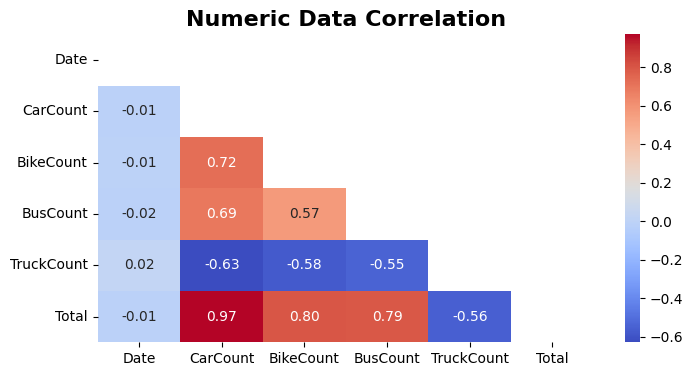

In [496]:
numeric = df.select_dtypes(include='number')
corr = numeric.corr()
mask = np.triu(np.ones_like(corr, dtype=float))

plt.figure(figsize=(8, 4))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numeric Data Correlation', fontsize=16, fontweight='bold')
plt.show()

In [497]:
'''plt.figure(figsize=(22, 22))
sns.pairplot(df)
plt.show()'''

'plt.figure(figsize=(22, 22))\nsns.pairplot(df)\nplt.show()'

##**5. Comparisson Between Categories**
---

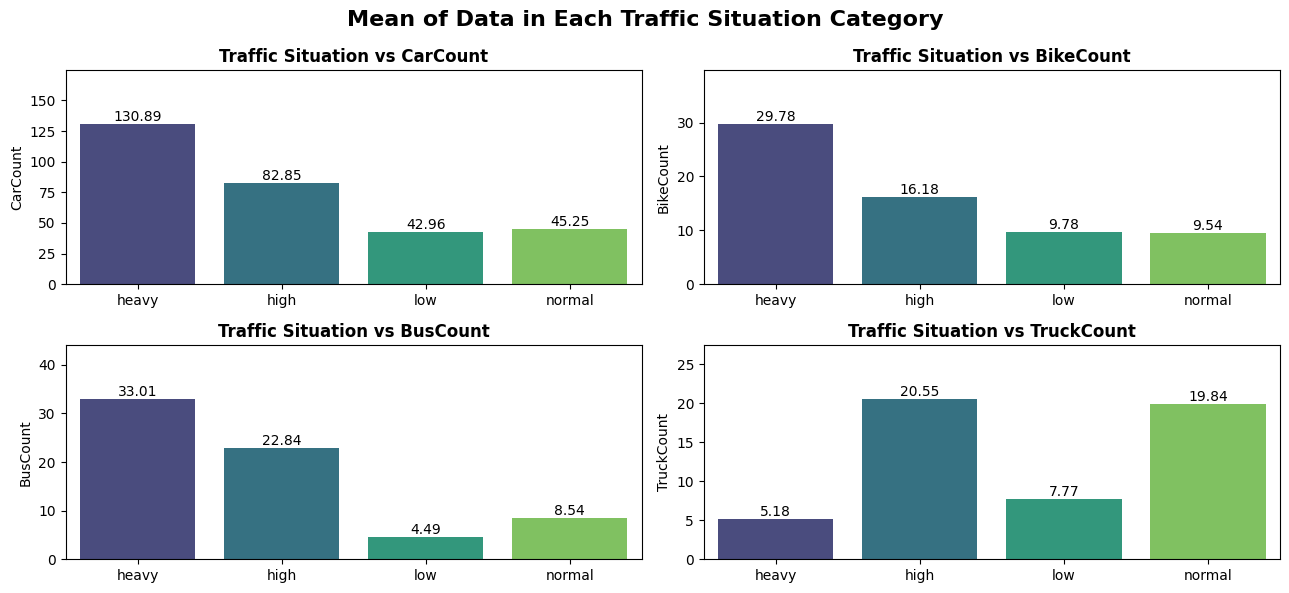

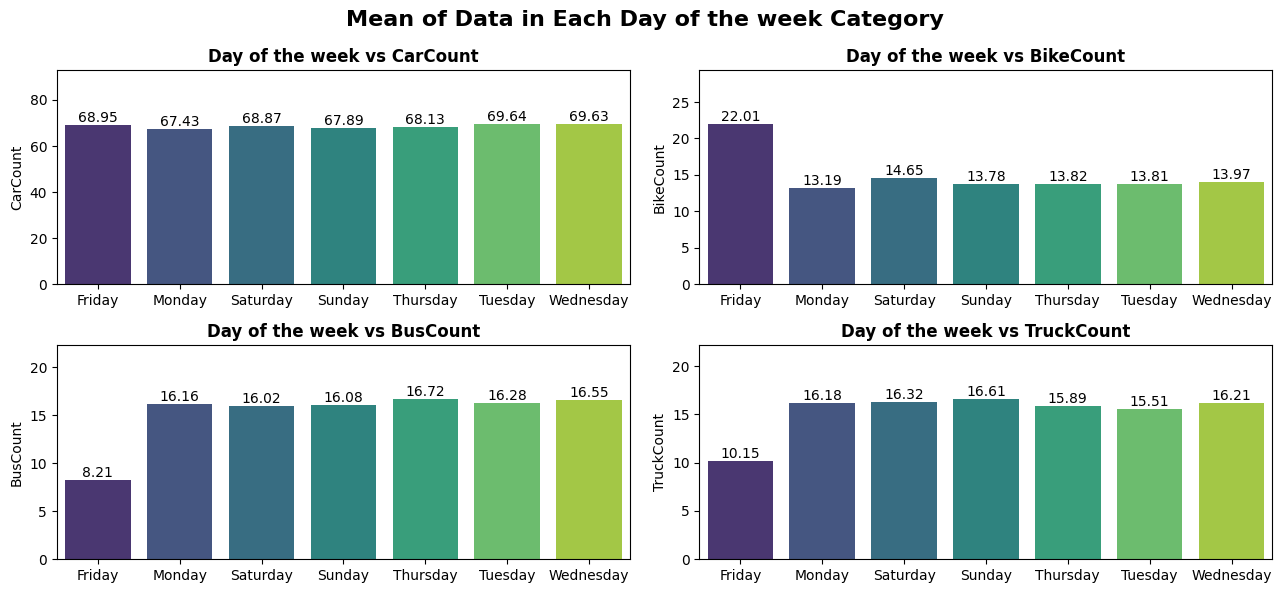

In [498]:
cat = ['Traffic Situation', 'Day of the week']

for column in cat:
  df_agg = df.groupby(by=column).agg({
      'CarCount': 'mean',
      'BikeCount': 'mean',
      'BusCount': 'mean',
      'TruckCount': 'mean'
  })
  plt.figure(figsize=(13, 6))
  for i, col in enumerate(df_agg.columns):
    plt.subplot(2, 2, i+1)
    ax = sns.barplot(x=df_agg.index.tolist(), y=df_agg[col], hue=df_agg.index.tolist(), palette='viridis')
    for value in ax.containers:
      label=[round(val.get_height(), 2) for val in value]
      ax.bar_label(value, labels=label, label_type='edge')
    plt.title(f'{column} vs {col}', fontsize=12, fontweight='bold')
    plt.ylim(ymax=df_agg[col].max() + (df_agg[col].max() / 3))
  plt.suptitle(f'Mean of Data in Each {column} Category', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()
  print(' ')

##**6. Comparisson Between Days**
---

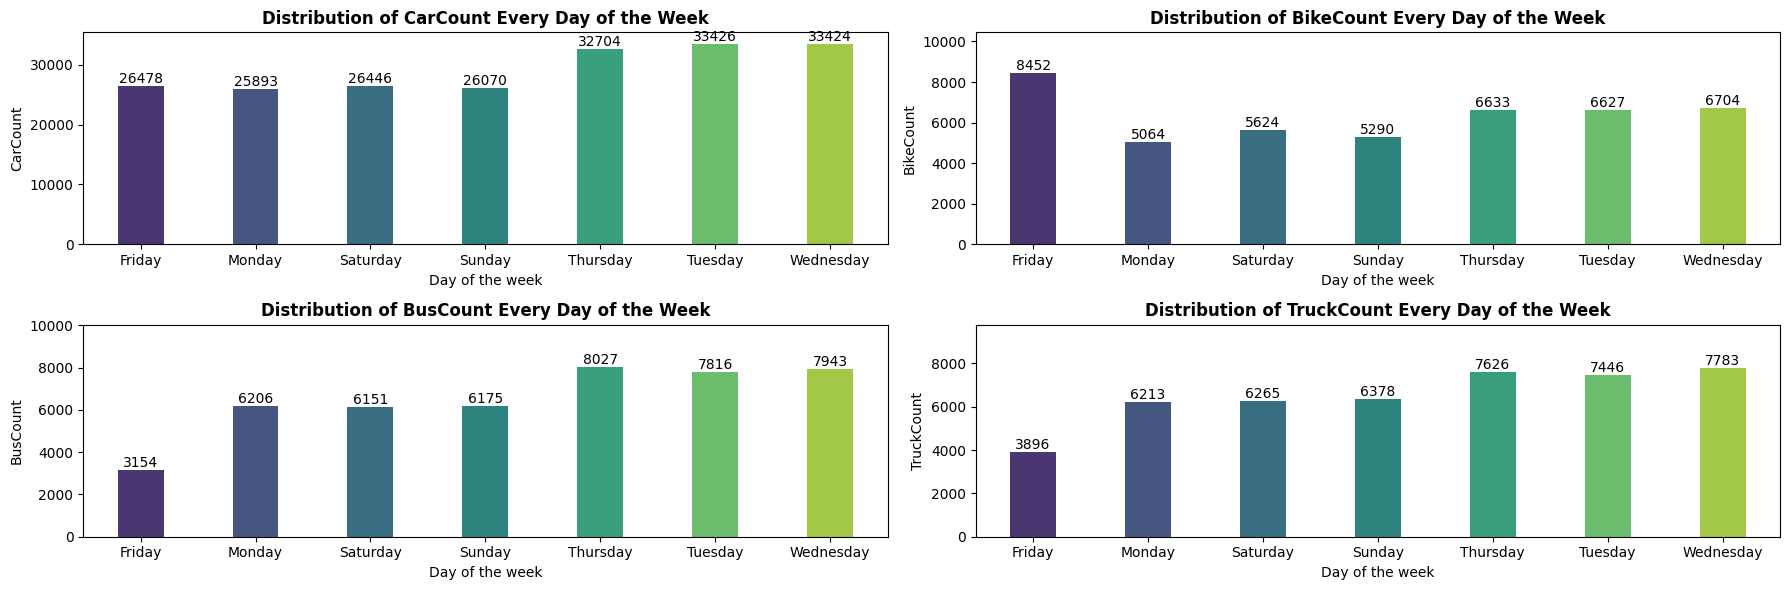

In [499]:
df_day = df.groupby(by='Day of the week').agg({
  'CarCount': 'sum',
  'BikeCount': 'sum',
  'BusCount': 'sum',
  'TruckCount': 'sum'
})

plt.figure(figsize=(18,6))
for i, col in enumerate(df_day.columns):
  plt.subplot(2, 2, i+1)
  ax = sns.barplot(x=df_day.index, y=df_day[col], hue=df_day.index, palette='viridis', gap=0.5, legend=False)
  for value in ax.containers:
    label=[val.get_height() for val in value]
    ax.bar_label(value, label=label, label_type='edge')
  plt.title(f'Distribution of {col} Every Day of the Week', fontsize=12, fontweight='bold')
  plt.ylim(ymax=df_day[col].max() + 2000)
plt.tight_layout()
plt.show()

#**Data Preparation**
---

##**1. Data Type Conversion**
---

In [500]:
date = [val for val in df['Date']]
time = [time for time in df['Time']]
result = []

for i in range(len(date)):
  result.append(f'{date[i]}/10/2025 {time[i]}')

df['Date_agg'] = result
df['Date_agg'] = pd.to_datetime(df['Date_agg'])
df.head()

/tmp/ipython-input-2600202203.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date_agg'] = pd.to_datetime(df['Date_agg'])


,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Date_agg
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low,2025-10-10 00:00:00
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low,2025-10-10 00:15:00
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low,2025-10-10 00:30:00
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low,2025-10-10 00:45:00
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal,2025-10-10 01:00:00


In [501]:
df['Time'] = pd.to_datetime(df['Time']).dt.hour

/tmp/ipython-input-3206695382.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.hour


##**2. Data Encoding**
---

###a. Encoding Day of the Week

In [502]:
df_new = pd.get_dummies(df, columns=['Day of the week'], dtype=int)
df_new.head()

,Time,Date,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Date_agg,Day of the week_Friday,Day of the week_Monday,Day of the week_Saturday,Day of the week_Sunday,Day of the week_Thursday,Day of the week_Tuesday,Day of the week_Wednesday
0,0,10,31,0,4,4,39,low,2025-10-10 00:00:00,0,0,0,0,0,1,0
1,0,10,49,0,3,3,55,low,2025-10-10 00:15:00,0,0,0,0,0,1,0
2,0,10,46,0,3,6,55,low,2025-10-10 00:30:00,0,0,0,0,0,1,0
3,0,10,51,0,2,5,58,low,2025-10-10 00:45:00,0,0,0,0,0,1,0
4,1,10,57,6,15,16,94,normal,2025-10-10 01:00:00,0,0,0,0,0,1,0


###b. Encoding Traffic Situation

In [503]:
def encode_situation(data):
  if data == 'low':
    return 0
  elif data == 'normal':
    return 1
  elif data == 'high':
    return 2
  elif data == 'heavy':
    return 3

df_new['Situation_Encoded'] = df_new['Traffic Situation'].apply(encode_situation)
df_new.drop(columns=['Traffic Situation', 'Total'], inplace=True)
df_new.head()

,Time,Date,CarCount,BikeCount,BusCount,TruckCount,Date_agg,Day of the week_Friday,Day of the week_Monday,Day of the week_Saturday,Day of the week_Sunday,Day of the week_Thursday,Day of the week_Tuesday,Day of the week_Wednesday,Situation_Encoded
0,0,10,31,0,4,4,2025-10-10 00:00:00,0,0,0,0,0,1,0,0
1,0,10,49,0,3,3,2025-10-10 00:15:00,0,0,0,0,0,1,0,0
2,0,10,46,0,3,6,2025-10-10 00:30:00,0,0,0,0,0,1,0,0
3,0,10,51,0,2,5,2025-10-10 00:45:00,0,0,0,0,0,1,0,0
4,1,10,57,6,15,16,2025-10-10 01:00:00,0,0,0,0,0,1,0,1


##**2. Feature Selection**
---

In [504]:
feature_input = [col for col in df_new.columns if col not in ['Situation_Encoded', 'Date_agg']]
feature_target = ['Situation_Encoded']

###a. Select K-Best

In [505]:
numerical = ['Time', 'Date', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount']
categoric = [
    'Day of the week_Monday', 'Day of the week_Saturday', 'Day of the week_Sunday', 'Day of the week_Thursday',
    'Day of the week_Tuesday', 'Day of the week_Wednesday']

In [506]:
selector = SelectKBest(score_func=chi2, k=4)
selector.fit(df_new[categoric], df_new['Situation_Encoded'])

score_df = pd.DataFrame({
    'score': selector.scores_
}, index=categoric).sort_values(by='score', ascending=False)
score_df

,score
Day of the week_Sunday,14.021425
Day of the week_Wednesday,8.838886
Day of the week_Saturday,8.467419
Day of the week_Thursday,7.310727
Day of the week_Tuesday,3.362100
Day of the week_Monday,1.364781


In [507]:
selector = SelectKBest(score_func=f_classif, k=4)
selector.fit(df_new[numerical], df_new['Situation_Encoded'])

score_df = pd.DataFrame({
    'score': selector.scores_
}, index=numerical).sort_values(by='score', ascending=False)
score_df

,score
CarCount,1555.698654
BusCount,1271.863720
BikeCount,724.357863
TruckCount,632.470458
Time,44.935974
Date,0.513765


In [508]:
cols_skbest = score_df.head(4).index.tolist()

###b. RFECV - Recursive Feature Elimination with Cross-Validation

In [509]:
rf = RandomForestClassifier()

selector = RFECV(
    estimator=rf,
    step=1,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
selector.fit(df_new[feature_input], df_new[feature_target])

result_df = pd.DataFrame({
    'use_feature': selector.support_
}, index=feature_input).sort_values(by='use_feature', ascending=False)
result_df

Fitting estimator with 13 features.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 12 features.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 11 features.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 10 features.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 9 features.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 8 features.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 7 features.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting estimator with 6 features.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,use_feature
Time,True
CarCount,True
BikeCount,True
BusCount,True
TruckCount,True
Date,False
Day of the week_Friday,False
Day of the week_Monday,False
Day of the week_Saturday,False
Day of the week_Sunday,False


In [510]:
cols_rfecv = result_df[result_df['use_feature'] == True].index.tolist()

##**3. Data Splitting & Undersampling**
---

In [511]:
x = df_new[cols_skbest]
y = df_new['Situation_Encoded']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
rus = RandomUnderSampler()
x_train, y_train = rus.fit_resample(x_train, y_train)

print(y_train.value_counts())

Situation_Encoded
0    243
1    243
2    243
3    243
Name: count, dtype: int64


##**4. Data Normalization**
---

In [512]:
scaler = StandardScaler()
scaler.fit(x_train)

x_nml = scaler.transform(x)
x_train_nml = scaler.transform(x_train)
x_test_nml = scaler.transform(x_test)

#**Data Modelling**
---

##**1. Naive Bayes Classifier**
---

Cross Validation Scores: [0.7962963  0.87345679 0.84259259]
Mean of Cross Validation Scores: 0.8374485596707819

Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        61
           1       0.96      0.62      0.75       334
           2       0.36      0.78      0.49        64
           3       0.90      0.97      0.93       137

    accuracy                           0.76       596
   macro avg       0.72      0.84      0.74       596
weighted avg       0.85      0.76      0.77       596



Text(0.5, 1.0, 'Confusion Matrix - Gaussian Naive Bayes')

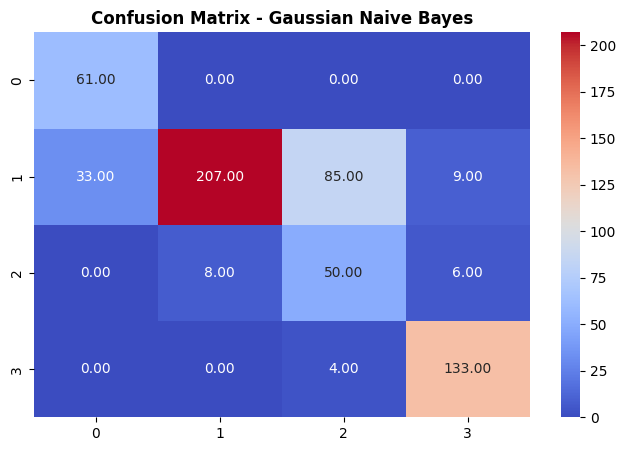

In [513]:
gnb = GaussianNB()
gnb.fit(x_train_nml, y_train)

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
cross_val = cross_val_score(gnb, x_train_nml, y_train, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

y_pred = gnb.predict(x_test_nml)
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix - Gaussian Naive Bayes', fontsize=12, fontweight='bold')

##**2. Support Vector Classifier**
---

Cross Validation Scores: [0.91666667 0.91975309 0.95987654]
Mean of Cross Validation Scores: 0.9320987654320988

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82        61
           1       1.00      0.85      0.92       334
           2       0.74      1.00      0.85        64
           3       0.95      0.96      0.96       137

    accuracy                           0.91       596
   macro avg       0.85      0.95      0.89       596
weighted avg       0.93      0.91      0.91       596



Text(0.5, 1.0, 'Confusion Matrix - SVC')

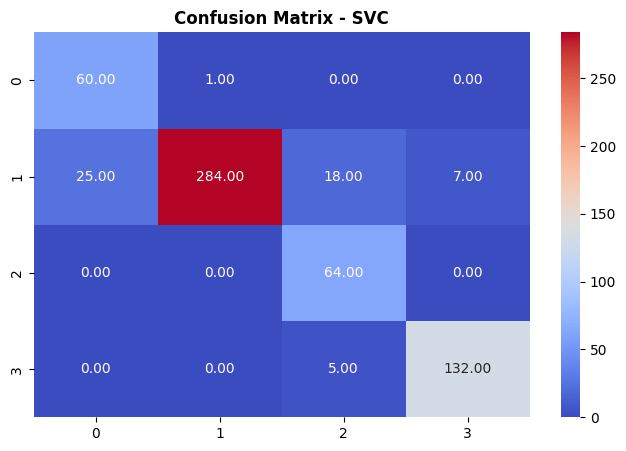

In [514]:
svc = SVC(kernel='rbf')
svc.fit(x_train_nml, y_train)

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
cross_val = cross_val_score(svc, x_train_nml, y_train, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

y_pred = svc.predict(x_test_nml)
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix - SVC', fontsize=12, fontweight='bold')

##**3. Random Forest Classifier**
---

Cross Validation Scores: [0.92592593 0.9537037  0.93209877]
Mean of Cross Validation Scores: 0.9372427983539096

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        61
           1       0.99      0.92      0.96       334
           2       0.81      0.97      0.88        64
           3       0.94      0.96      0.95       137

    accuracy                           0.94       596
   macro avg       0.91      0.96      0.93       596
weighted avg       0.95      0.94      0.95       596



Text(0.5, 1.0, 'Confusion Matrix - Random Forest')

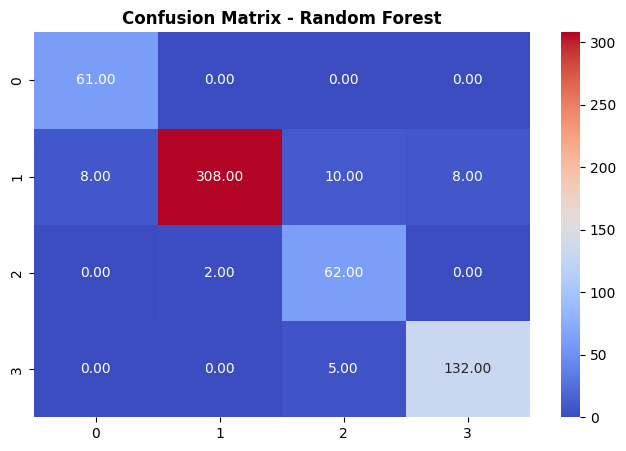

In [515]:
rfc = RandomForestClassifier()
rfc.fit(x_train_nml, y_train)

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
cross_val = cross_val_score(rfc, x_train_nml, y_train, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

y_pred = rfc.predict(x_test_nml)
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix - Random Forest', fontsize=12, fontweight='bold')

##**4. Data Clustering**
---

###a. Feature Selection

In [516]:
df_cl = df_new[[col for col in df_new.columns if col not in ['Situation_Encoded', 'Date_agg']]]

####a.1. Variance Threshold

In [517]:
scaler = MinMaxScaler()
df_cl_scaled = scaler.fit_transform(df_cl)

vt = VarianceThreshold(threshold=0.01)
x_variance = vt.fit_transform(df_cl_scaled)

result_vt = pd.DataFrame({
    'result': vt.get_support().tolist()
}, index=df_cl.columns)
result_vt

,result
Time,True
Date,True
CarCount,True
BikeCount,True
BusCount,True
TruckCount,True
Day of the week_Friday,True
Day of the week_Monday,True
Day of the week_Saturday,True
Day of the week_Sunday,True


####a.2. MCFS

In [518]:
mcfs = MCFS.mcfs(df_cl.values, n_selected_features=5, k=5)

result_mcfs = pd.DataFrame({
    'result_score': mcfs.tolist()
}, index=df_cl.columns).sort_values(by='result_score', ascending=False)
result_mcfs

,result_score
Day of the week_Wednesday,12
Day of the week_Tuesday,11
Day of the week_Thursday,10
Day of the week_Sunday,9
Day of the week_Saturday,8
Day of the week_Monday,7
Day of the week_Friday,6
TruckCount,5
BusCount,4
BikeCount,3


In [519]:
cols_for_use = result_mcfs.head(11).index.tolist()

###b. K-Means Clustering

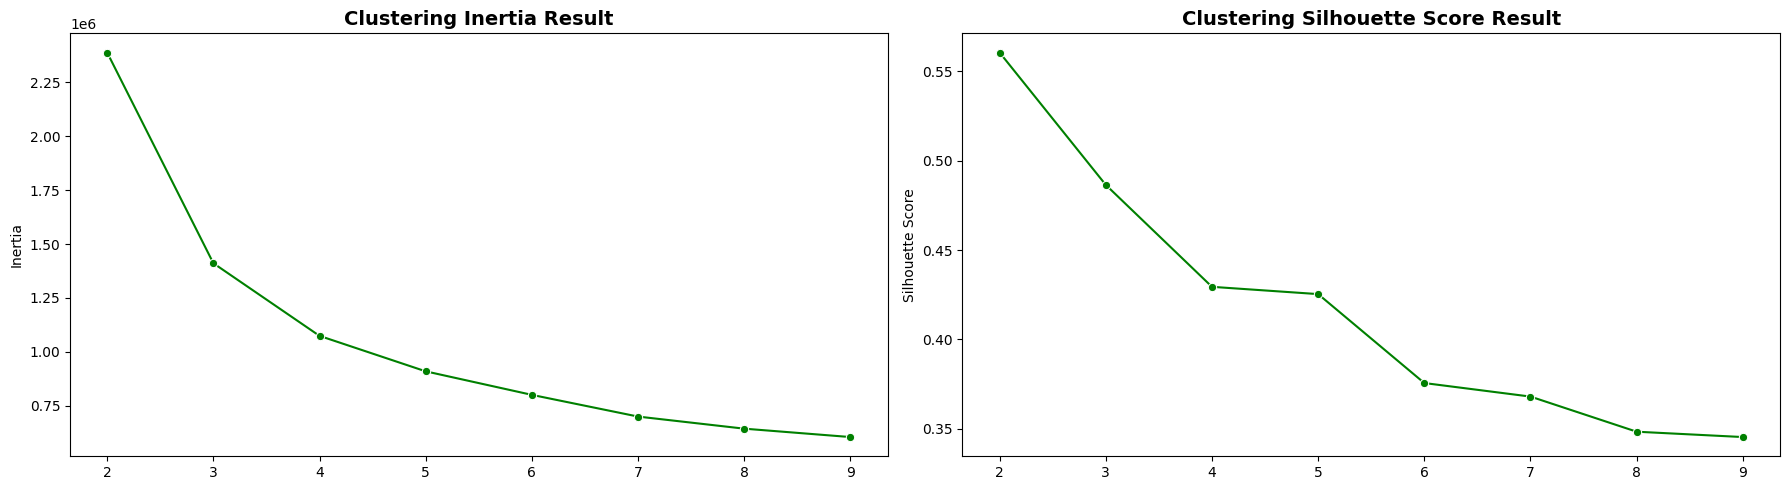

In [520]:
inertia, sil_score = [], []
n_clusters = range(2, 10)
df_cl = df_cl[cols_for_use]


for cl in n_clusters:
  kmeans = KMeans(n_clusters=cl, random_state=42)
  kmeans.fit(df_cl)
  label = kmeans.labels_

  inertia.append(kmeans.inertia_)
  sil_score.append(silhouette_score(df_cl, label, metric='euclidean'))

df_result = pd.DataFrame({
    'Inertia': inertia,
    'Silhouette Score': sil_score
}, index=n_clusters)

plt.figure(figsize=(18, 5))
for i, col in enumerate(df_result):
  plt.subplot(1, 2, i+1)
  sns.lineplot(x=df_result.index.tolist(), y=df_result[col], color='green', marker='o')
  plt.title(f'Clustering {col} Result', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [521]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_cl)
label = kmeans.labels_

silhouette = silhouette_score(df_cl, label, metric='euclidean')
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.4865230403819656


In [522]:
df_cl['cluster'] = kmeans.fit_predict(df_cl)
df_new['cluster'] = kmeans.fit_predict(df_new[cols_for_use])

#**Clustering Results**
---

##**1. General Summary**
---

In [523]:
df_cl_agg = df_cl.groupby(by='cluster').mean()
df_cl_agg

,Day of the week_Wednesday,Day of the week_Tuesday,Day of the week_Thursday,Day of the week_Sunday,Day of the week_Saturday,Day of the week_Monday,Day of the week_Friday,TruckCount,BusCount,BikeCount,CarCount
cluster,,,,,,,,,,,
0,0.160752,0.169102,0.153445,0.139875,0.124217,0.130480,0.122129,16.130480,13.902923,15.156576,71.710856
1,0.167592,0.166482,0.172031,0.125416,0.135405,0.126526,0.106548,5.899001,30.038846,26.753607,125.800222
2,0.156670,0.150403,0.159355,0.122650,0.128021,0.129812,0.153089,22.237243,4.555058,5.164727,20.050134


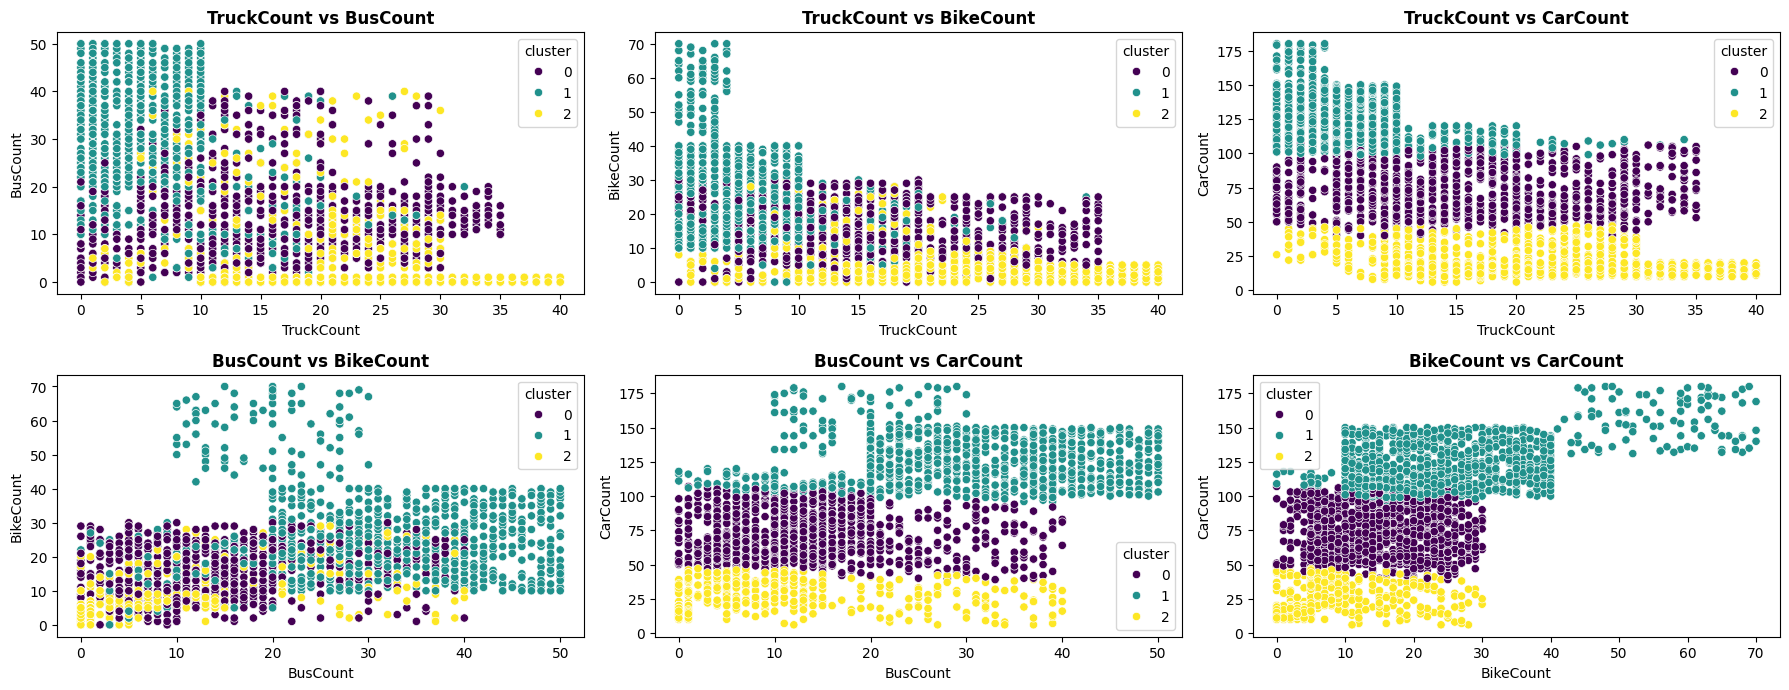

In [524]:
cols_forbid = [
    'Day of the week_Wednesday', 'Day of the week_Tuesday','Day of the week_Thursday', 'Day of the week_Sunday',
    'Day of the week_Friday', 'Day of the week_Saturday', 'Day of the week_Monday', 'cluster'
]
cols_to_use = [col for col in df_cl.columns if col not in cols_forbid]
i = 0

plt.figure(figsize=(18, 10))
for col in cols_to_use:
  cols_forbid.append(col)
  for column in cols_to_use:
    if column in cols_forbid:
      continue
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=df_cl[col], y=df_cl[column], hue=df_cl['cluster'], palette='viridis')
    plt.title(f'{col} vs {column}', fontsize=12, fontweight='bold')
    i+=1
plt.tight_layout()
plt.show()

##**2. Data Distribution of Each Clusters**
---

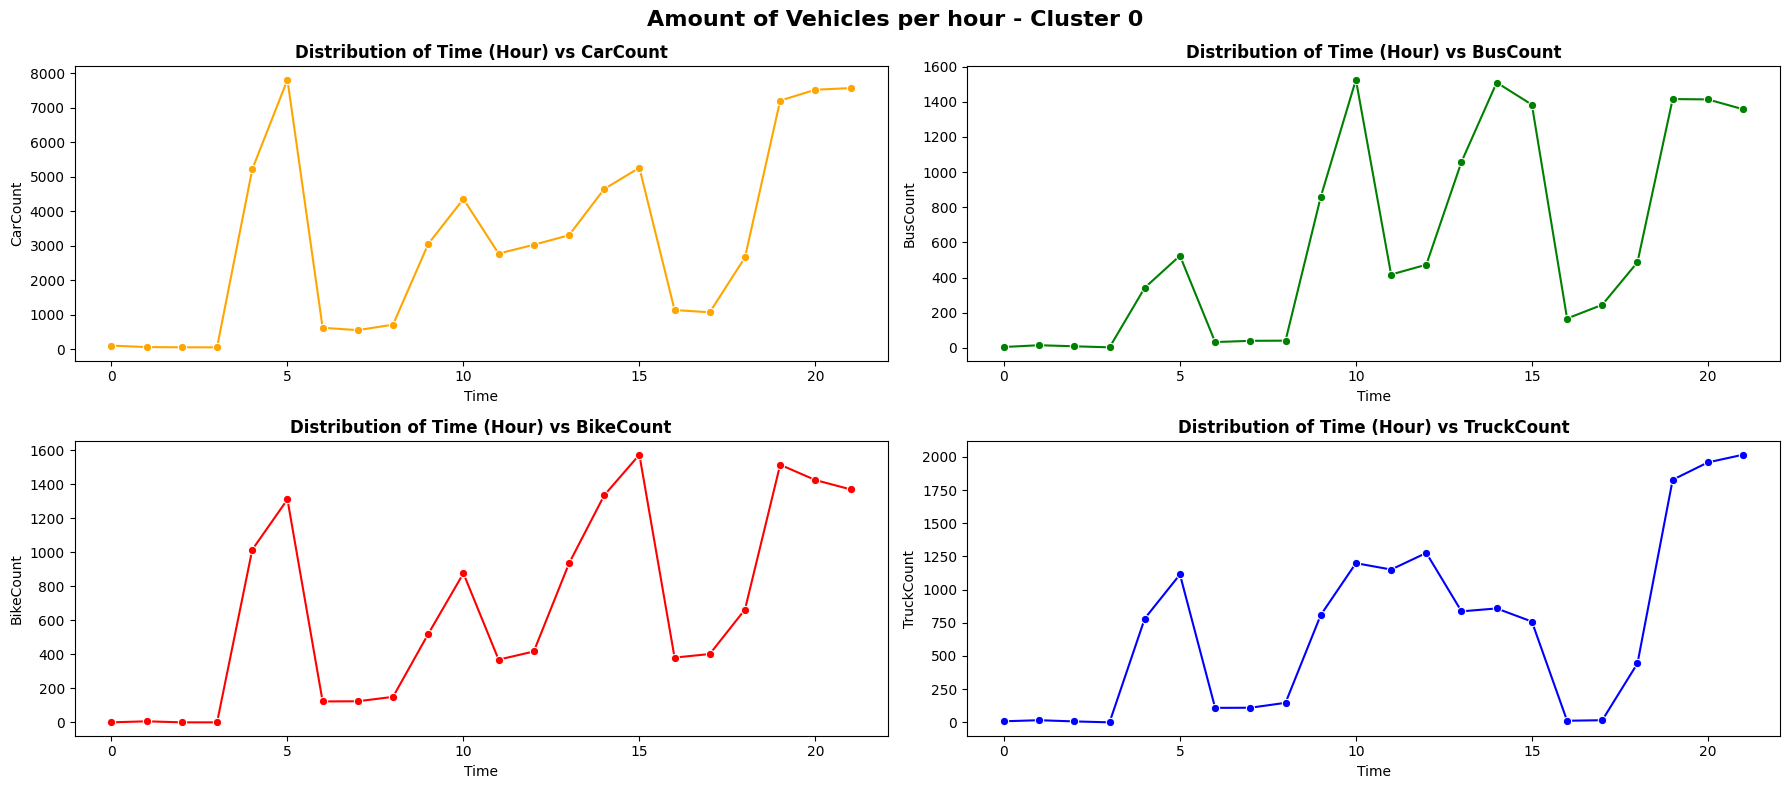

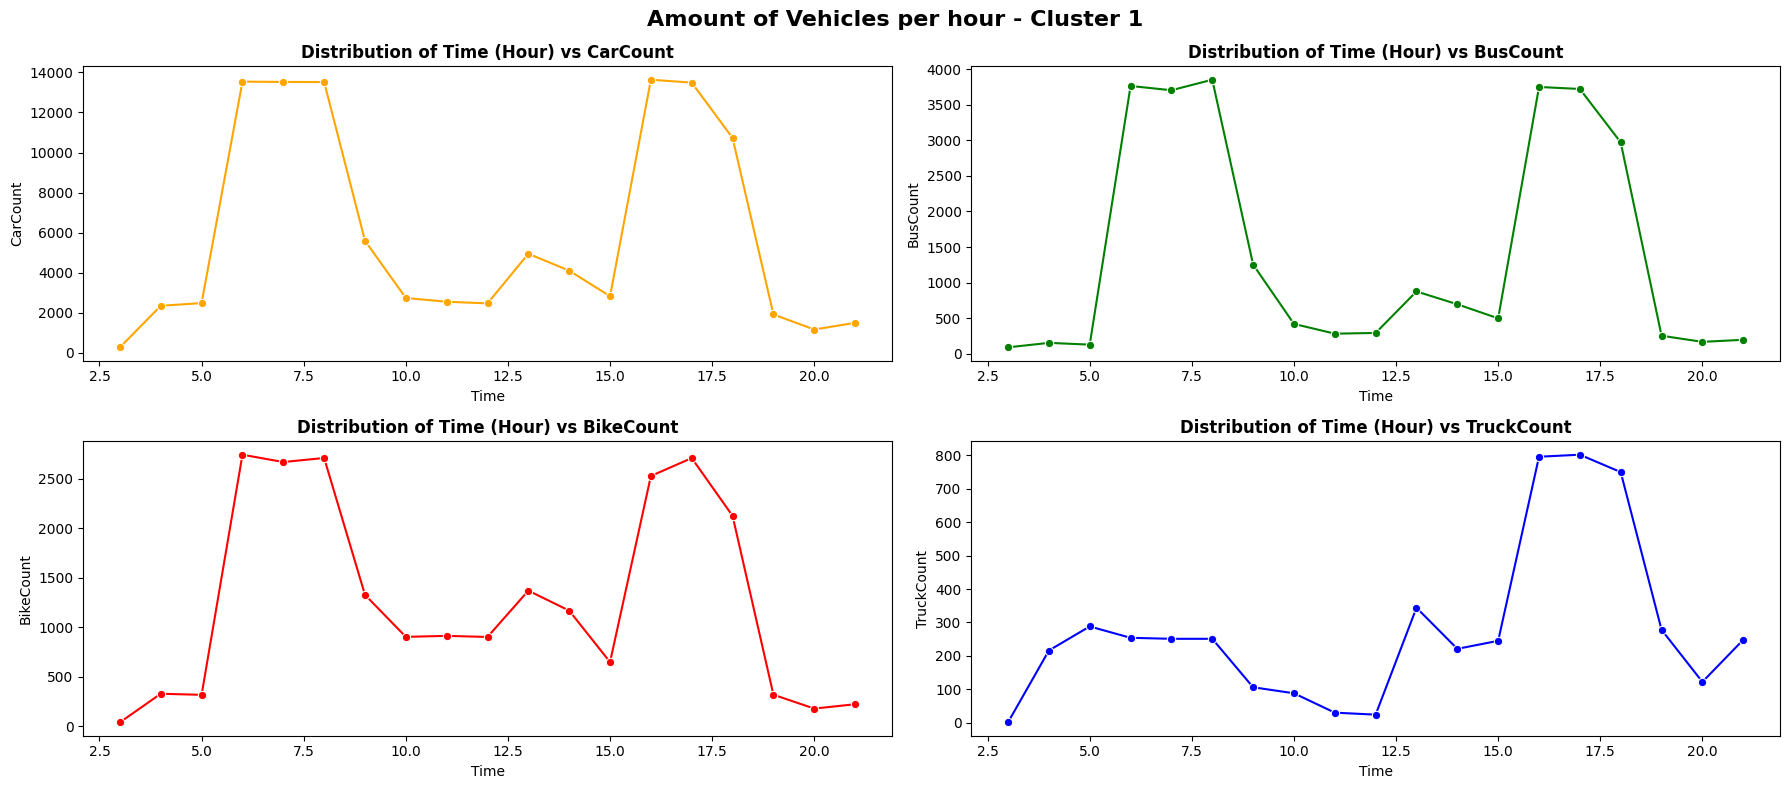

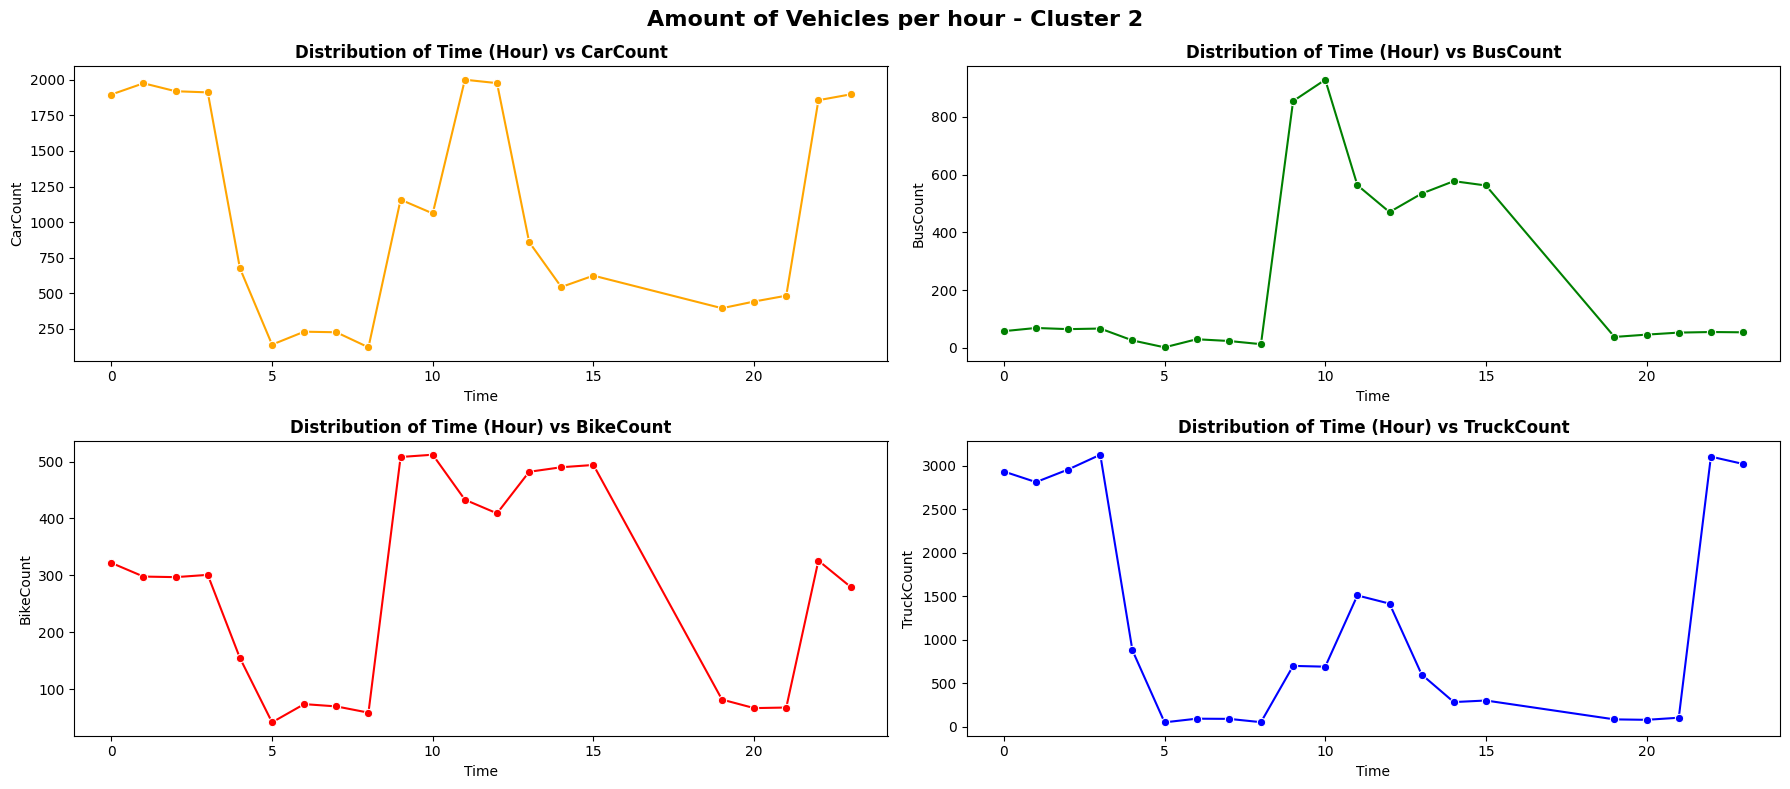

In [525]:
colors = ['orange', 'green', 'red', 'blue']
df_cluster_0 = df_new[df_new['cluster'] == 0]
df_cluster_1 = df_new[df_new['cluster'] == 1]
df_cluster_2 = df_new[df_new['cluster'] == 2]
df_clusters = {
    'Cluster 0': df_cluster_0,
    'Cluster 1': df_cluster_1,
    'Cluster 2': df_cluster_2
}

for data in df_clusters:
  df_cluster = df_clusters[data]
  df_cl_agg = df_cluster.groupby(by='Time').agg({
      'CarCount': 'sum',
      'BusCount': 'sum',
      'BikeCount': 'sum',
      'TruckCount': 'sum'
  })

  plt.figure(figsize=(18, 8))
  for i, col in enumerate(df_cl_agg.columns):
    plt.subplot(2, 2, i+1)
    sns.lineplot(x=df_cl_agg.index, y=df_cl_agg[col], marker='o', color=colors[i])
    plt.title(f'Distribution of Time (Hour) vs {col}', fontsize=12, fontweight='bold')
  plt.suptitle(f'Amount of Vehicles per hour - {data}', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()
  print(' ')

In [526]:
def day_aggr(data):
  aggr = data.groupby(by='cluster').agg({
      'Day of the week_Monday': 'sum',
      'Day of the week_Tuesday': 'sum',
      'Day of the week_Wednesday': 'sum',
      'Day of the week_Thursday': 'sum',
      'Day of the week_Friday': 'sum',
      'Day of the week_Saturday': 'sum',
      'Day of the week_Sunday':'sum'
  }).transpose()
  idx = [i.split('_')[1] for i in aggr.index.tolist()]
  vals = aggr.values.flatten().tolist()
  return idx, vals

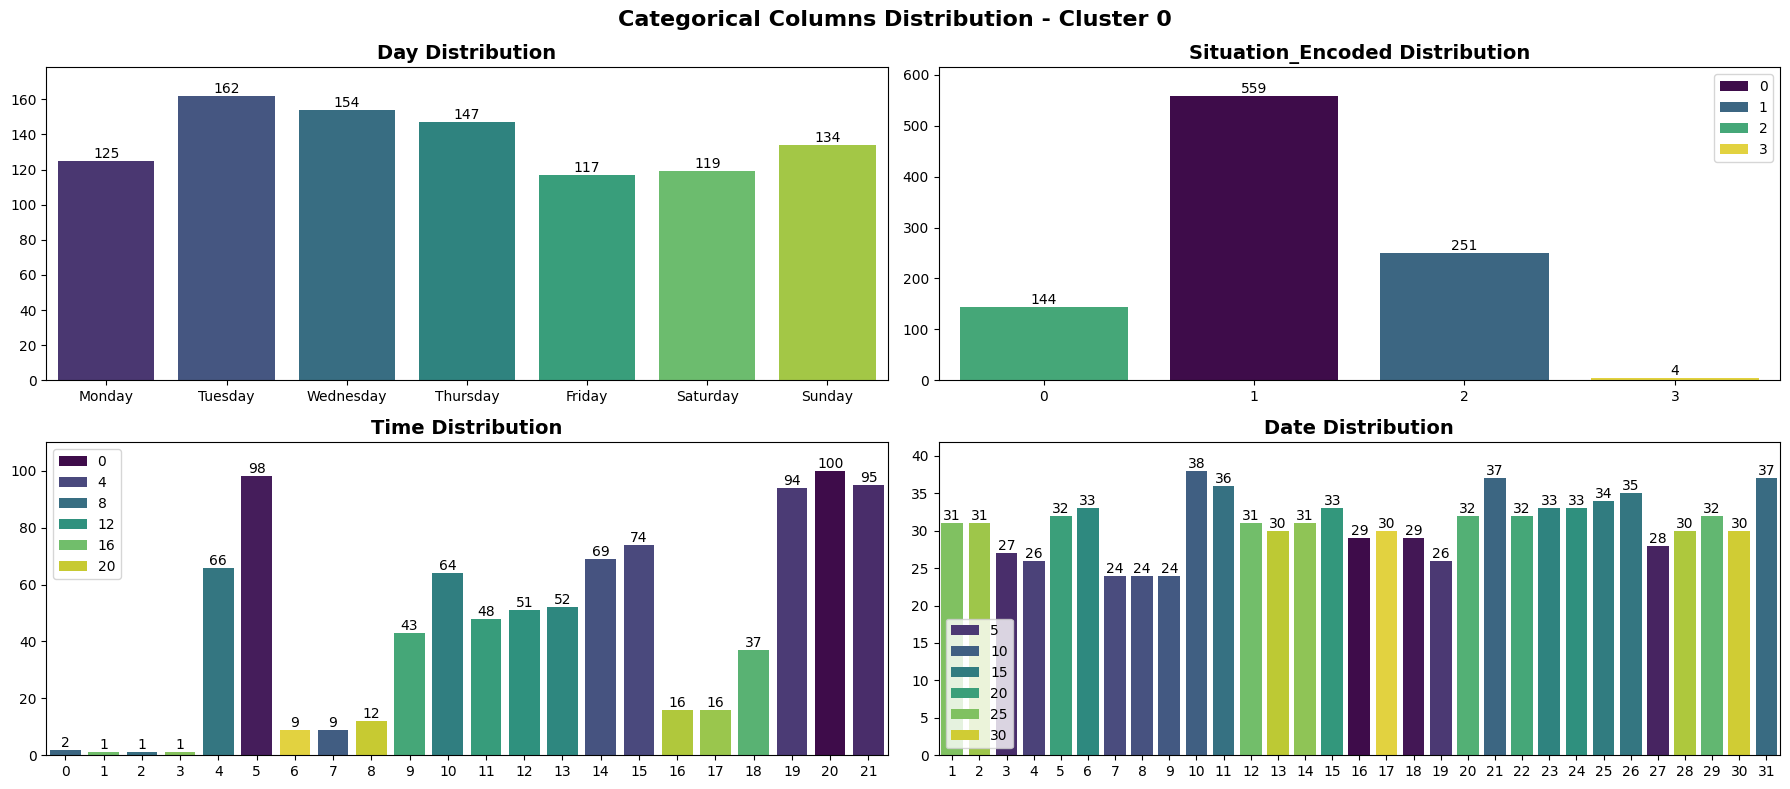

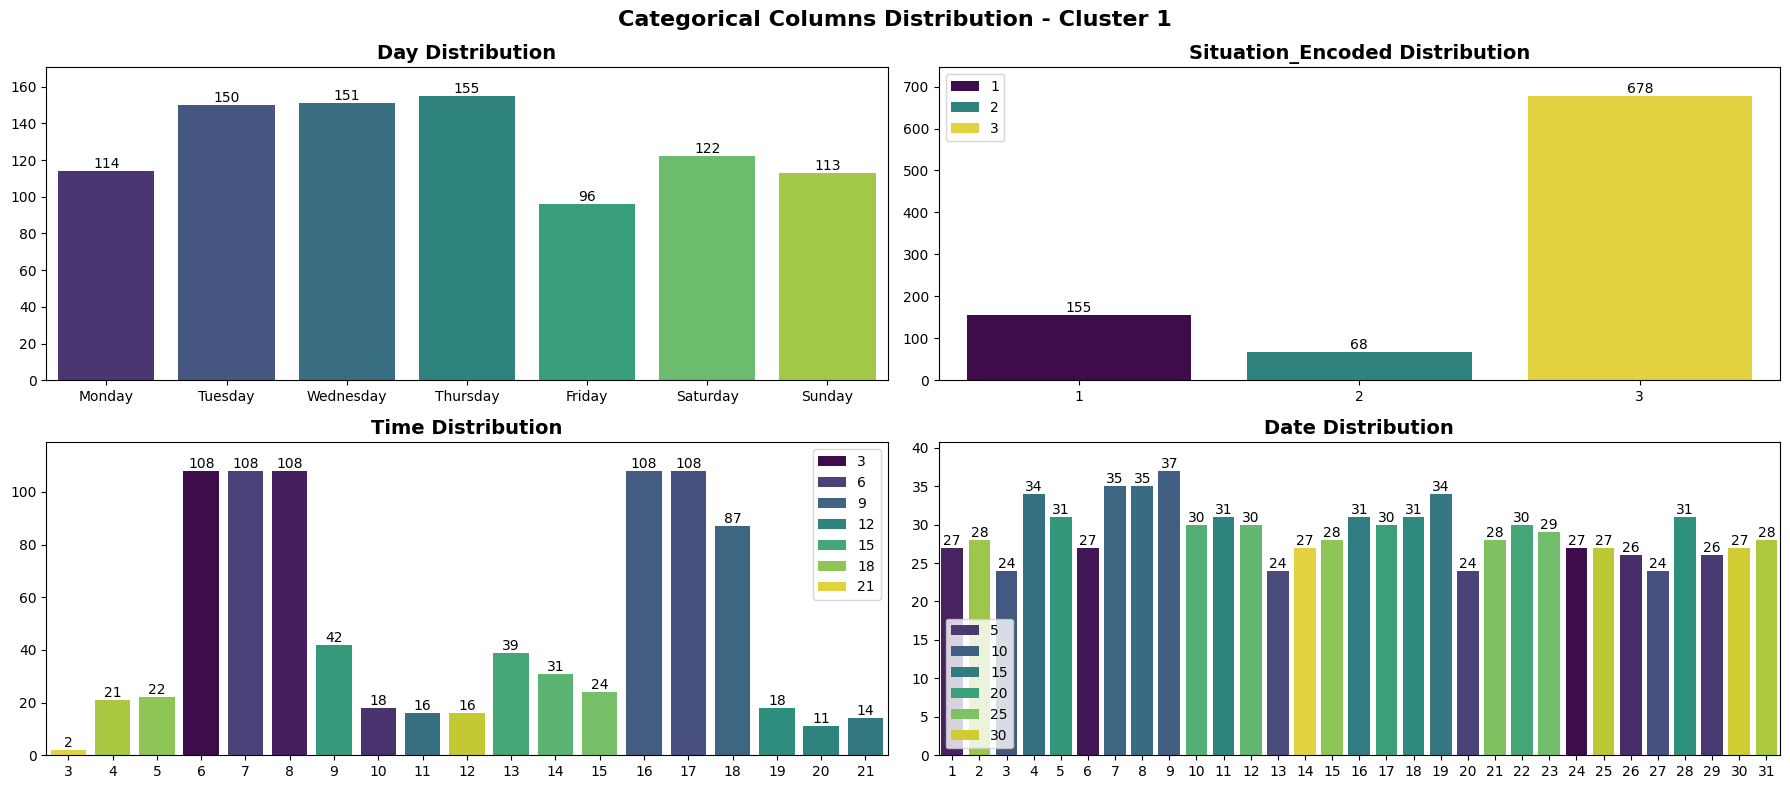

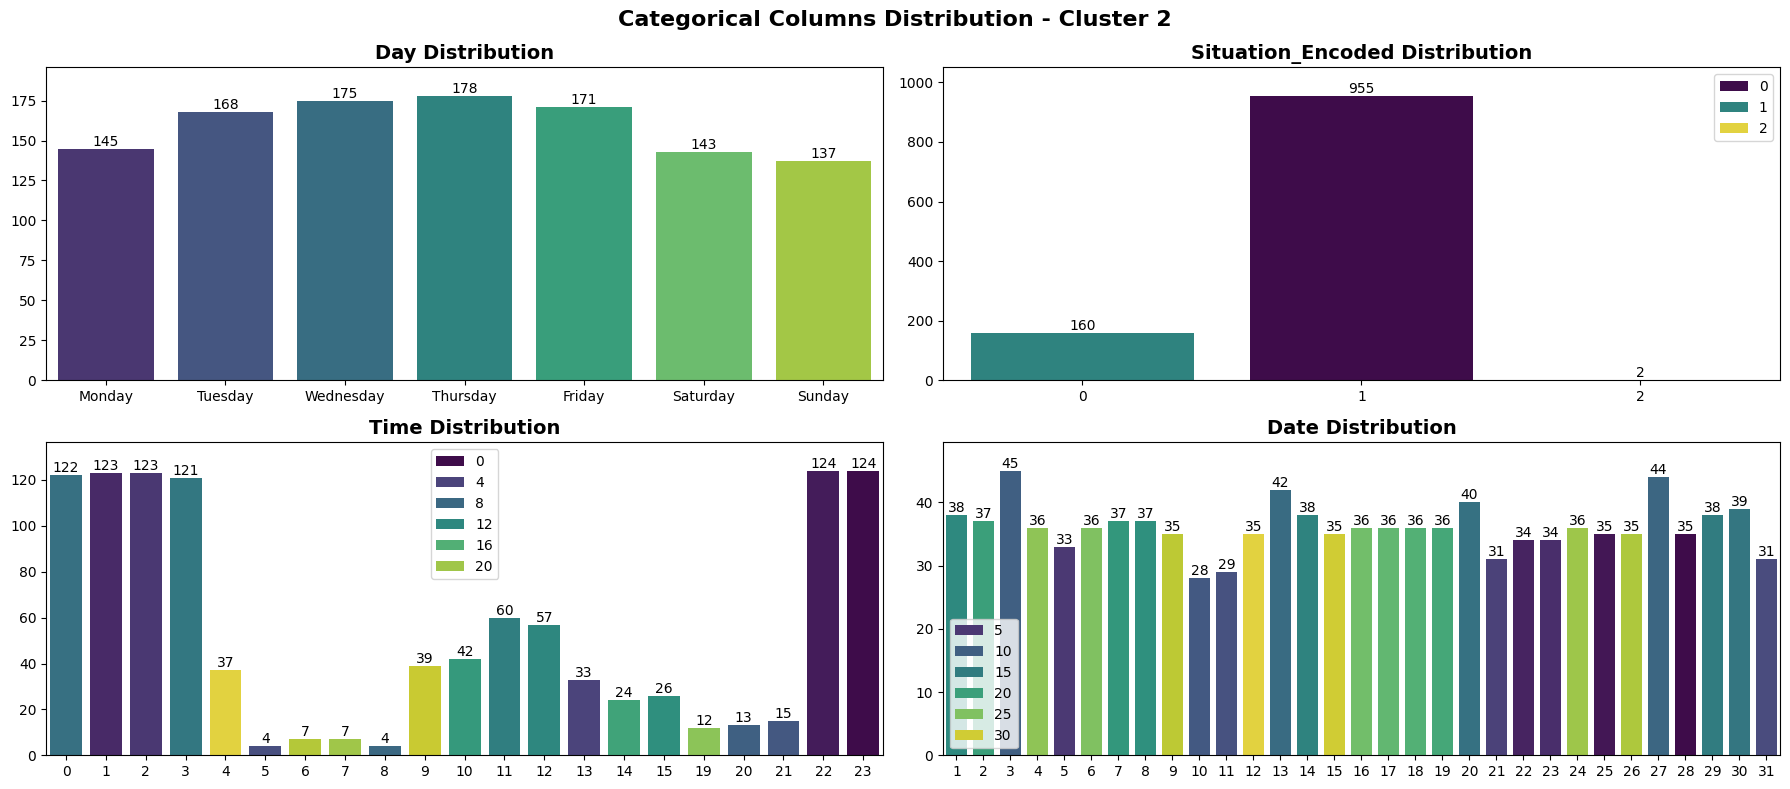

In [527]:
cols = ['Day', 'Situation_Encoded', 'Time', 'Date']
df_cluster_0 = df_new[df_new['cluster'] == 0]
df_cluster_1 = df_new[df_new['cluster'] == 1]
df_cluster_2 = df_new[df_new['cluster'] == 2]
df_clusters = {
    'Cluster 0': df_cluster_0,
    'Cluster 1': df_cluster_1,
    'Cluster 2': df_cluster_2
}

for data in df_clusters:
  df_cluster = df_clusters[data]

  plt.figure(figsize=(18,8))
  for i, col in enumerate(cols):
    plt.subplot(2, 2, i+1)
    if col == 'Day':
      idx, vals = day_aggr(df_cluster)
      ax = sns.barplot(x=idx, y=vals, hue=idx, palette='viridis')
      for values in ax.containers:
        label = [val for val in values]
        ax.bar_label(values, label=label, label_type='edge')
      plt.ylim(ymax=max(vals) + (max(vals)/10))
    else:
      counts = df_cluster[col].value_counts()
      ax = sns.barplot(x=counts.index.tolist(), y=counts.values.tolist(), hue=df_cluster[col].unique(), palette='viridis')
      for values in ax.containers:
        label = [val for val in values]
        ax.bar_label(values, label=label, label_type='edge')
      plt.ylim(ymax=counts.max() + (counts.max()/10))
    plt.title(f'{col} Distribution', fontsize=14, fontweight='bold')
  plt.suptitle(f'Categorical Columns Distribution - {data}', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()
  print()

#**Conclusion**
---
The results of the classification model created in this project have yielded satisfactory results, with precision, recall, and f1 scores being high. The best performing model mwoul be the Random Forest Classifier, whose f1 score averaged around 90%. This proves that the pattern found on this dataset is representative of the differences between low, normal, high, and heavy traffic.

At the same time, there are several key factors which contributed to the intensity of traffic, including:
1. **CarCount**: the number of cars present, where higher numbers mean higher chance of traffic congestion.
2. **BusCount**: the number of busses present, where higher numbers mean higher chance of traffic congestion.
3. **TruckCount**: number of trucks present at traffic, where higher numbers mean higher chance of traffic congestion.
4. **BikeCount**: the number of bikes present, where higher numbers mean higher chance of traffic congestion.

On the other hand, the clustering results are somewhat less conclusive, though significant insights could still be found:
1. **Cluster 0**: In this cluster, the dominant **traffic situation is normal, with a small number of low and high traffic situations**. The data of this cluster is also distributed almost evenly across many hours of the day. This shows that the data in this cluster **shows the typical day to day traffic situation**, and as such cloud be classed as the 'normal' condition. Due to this, similar to cluster 2, data in this cluster is ***also of low concern***.
2. **Cluster 1**: In this cluster, there are **high numbers of cars, busses, and bikes**, and has a significant number (more than 75% of this cluster's observation) of **heavy traffic situations**. This is also illustrated by the **high number of vehicles** on this cluster. Lastly, from this cluster it could be found that **heavy traffic can be found at specific hours of the day, like from 06:00 to 08:00 and from 16:00 to 18:00**. This shows that the traffic situation of this cluster is mostly congested, and as such, ***should have the highest urgency to be handled***.
3. **Cluster 2**: This cluster is dominated by **normal or low traffic congestion**. Overall, there are **high numbers of trucks** on this cluster, but **low numbers of bikes, busses and cars**. Also, the data of this cluster are mostly at **early and late hours of the day**, showing that the traffic activity is mostly low to normal during this time of the day. This shows that the ***traffic situation at this cluster is of the lowest-concern***.

Based on these results, in could be concluded that worse traffic conditions tend to be characterized by a high number of vehicles. These traffic congestions tend to have a pattern, happening during rush hours (in the morning, from 06:00-08:00 and in the afternoon, from 16:00-18:00). The classification model was able to detect these congestions fairly well, and the clustering results were able to identify data where the traffic situation is particularly severe, and these clusters could be used to determine specific treatments or actions that should be done in order to deal with traffic conditions more appropriately.

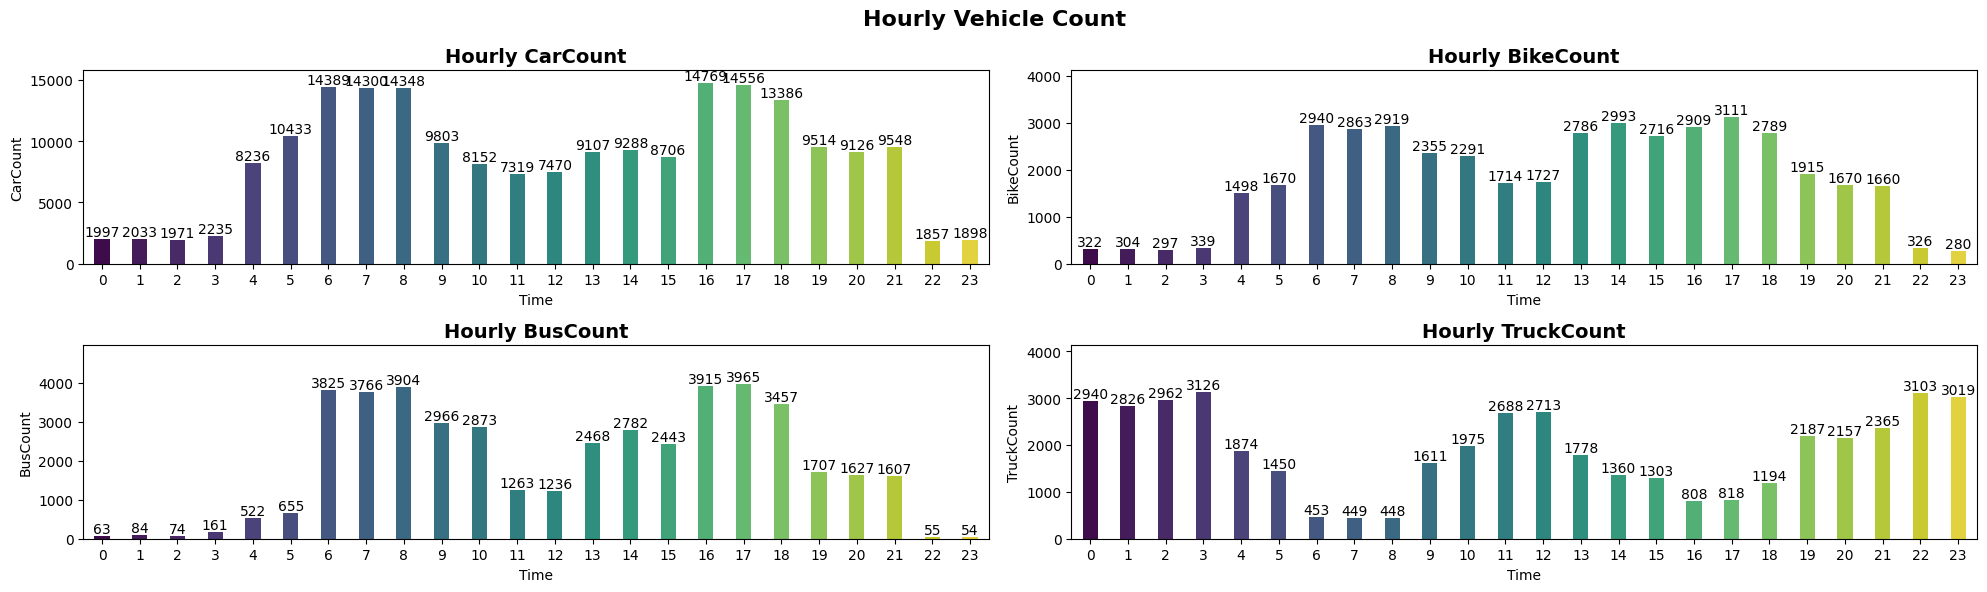

In [528]:
df_hourly = df.groupby(by='Time').agg({
  'CarCount': 'sum',
  'BikeCount': 'sum',
  'BusCount': 'sum',
  'TruckCount': 'sum'
})

plt.figure(figsize=(20, 6))
for i, col in enumerate(df_hourly.columns):
  plt.subplot(2, 2, i+1)
  ax = sns.barplot(x=df_hourly.index, y=df_hourly[col], hue=df_hourly.index, palette='viridis', gap=0.5, legend=False)
  for value in ax.containers:
    label=[val.get_height() for val in value]
    ax.bar_label(value, label=label, label_type='edge')
  plt.title(f'Hourly {col}', fontsize=14, fontweight='bold')
  plt.ylim(ymax=df_hourly[col].max() + 1000)
plt.suptitle(f'Hourly Vehicle Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

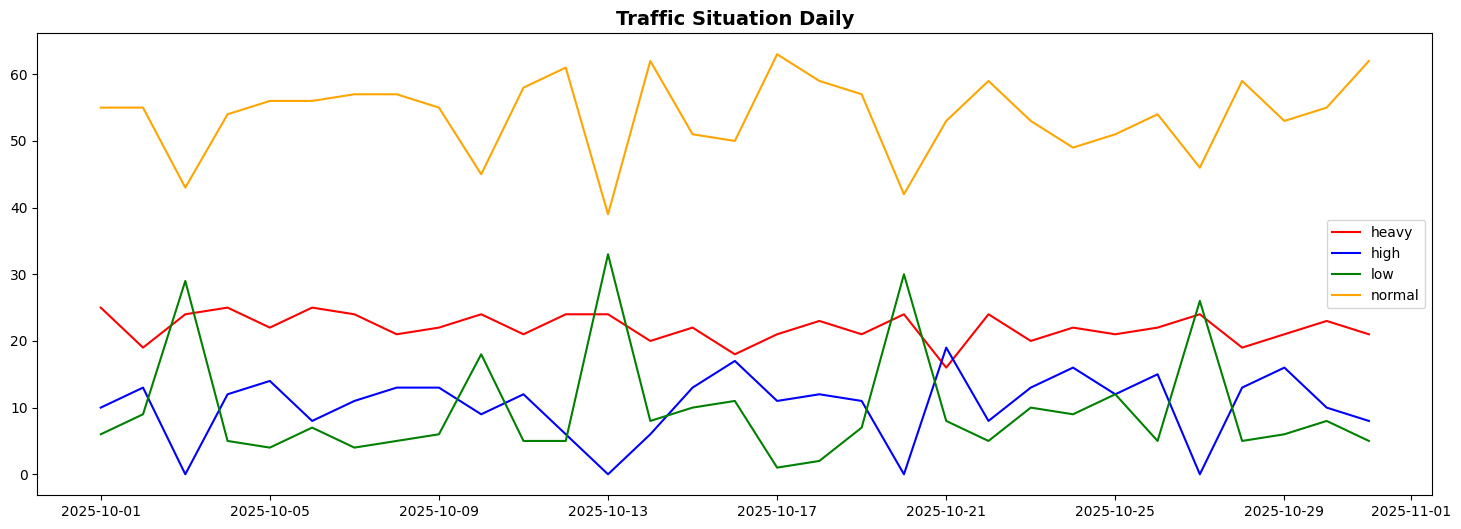

In [529]:
dates = []
for val in df['Date']:
  dates.append(f'2025/10/{val}')

df_new_2 = df.copy()
df_new_2['Date_Only'] = dates
df_new_2['Date_Only'] = pd.to_datetime(df_new_2['Date_Only'])

df_new_2_agg = df_new_2.pivot_table(columns='Traffic Situation', index='Date_Only', values='Date_agg', aggfunc='count')
df_new_2_agg.fillna(0, inplace=True)

color = ['red', 'blue', 'green', 'orange']
plt.figure(figsize=(18, 6))
for i, col in enumerate(df_new_2_agg.columns):
  plt.plot(df_new_2_agg.index.tolist(), df_new_2_agg[col], color=color[i], label=col)
plt.title('Traffic Situation Daily', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

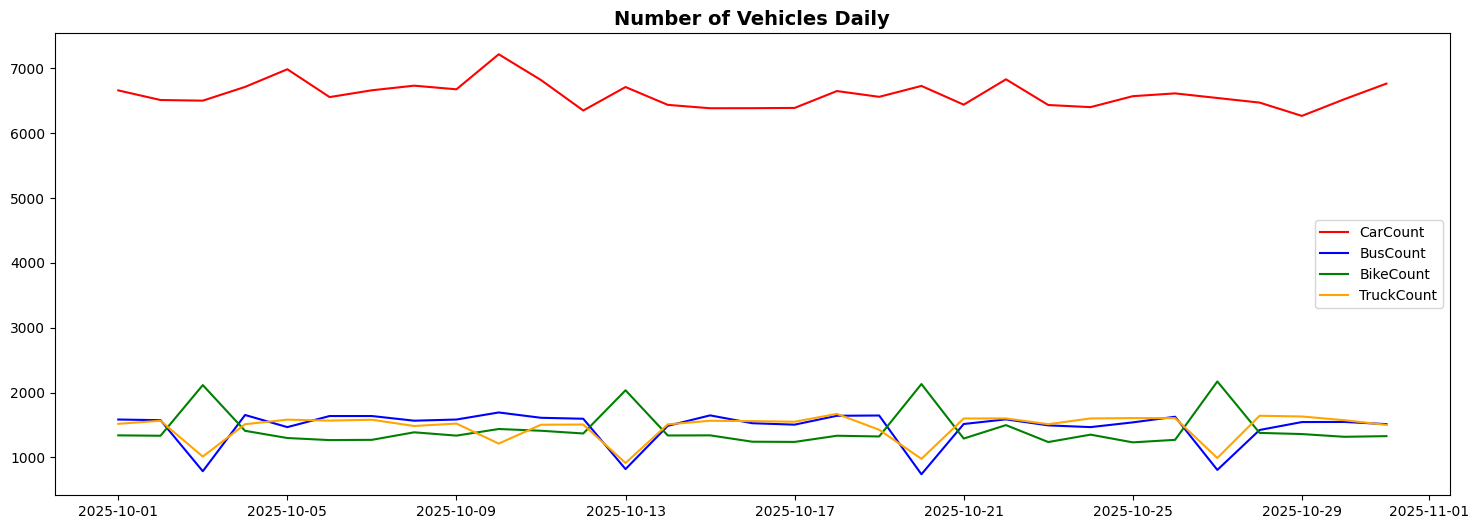

In [530]:
df_new_2_agg2 = df_new_2.groupby(by='Date_Only').agg({
    'CarCount': 'sum',
    'BusCount': 'sum',
    'BikeCount': 'sum',
    'TruckCount': 'sum',
})

color = ['red', 'blue', 'green', 'orange']
plt.figure(figsize=(18, 6))
for i, col in enumerate(df_new_2_agg2.columns):
  plt.plot(df_new_2_agg2.index.tolist(), df_new_2_agg2[col], color=color[i], label=col)
plt.title('Number of Vehicles Daily', fontsize=14, fontweight='bold')
plt.legend()
plt.show()